# DNS Exfiltration Detection Using Python and Pandas: A Network Traffic Analytics Approach
By Herbert Maosa  
Cybersecurity Consultant | PhD | CISSP | OSCP

---
"***Most networks let DNS traffic pass without a second thought — and that's exactly what attackers are counting on***."

**DNS exfiltration** is a stealthy cyberattack in which sensitive data — such as passwords, source code, or trade secrets — is smuggled out of a network inside DNS queries. Since DNS traffic is rarely blocked or closely scrutinized, attackers can encode payloads into domain lookups and quietly bypass firewalls. The exfiltrated data often travels in query names or payloads, unnoticed.

Detecting DNS exfiltration involves identifying subtle anomalies, such as:

- Excessively long or random-looking domain names
- High volumes of DNS queries to suspicious or rarely seen domains
- Unusual query types or response behaviors
- Regular time intervals between queries
- Queries occurring at abnormal times (e.g., nights/weekends)
- High entropy or randomness in query names
- Excessive subdomains under a single root domain
- Anomalous distributions of response codes and types

In this notebook, I present a framework for detecting data exfiltration over DNS. It is designed to be an evolving resource — enriched with new analyses as I encounter them in real-world threat hunts. The goal is to bridge theory and practice using Python, Pandas, and real PCAP data to demonstrate how even stealthy DNS traffic can reveal a breach in progress.

---
## 1. Imports and Dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../Scripts")) # to find our heavy lifting code in the scripts/ folder.

In [2]:
import json
import pandas as pd
import numpy as np
import math
import ipywidgets as widgets
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display
import seaborn as sns
import tldextract
from ipyfilechooser import FileChooser
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from process_pcap import process_dns
from dns_utils import shannon_entropy, map_dns_subdomains

sns.set(style='whitegrid')
plt.close('all')
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*")

---
For this Notebook, we analyze the [CIC-Bell-DNS-EXF-2021 dataset](https://www.unb.ca/cic/datasets/dns-exf-2021.html) by the Canadian Institute of Cyber Security- a well-known benchmark in cybersecurity research, particularly for DNS exfiltration detection. This dataset is provided in two formats:
- A CSV file with ~30 pre-engineered features for machine learning
- A raw PCAP file containing full packet captures.

Although the PCAP includes other protocols, we focused exclusively on DNS traffic to investigate potential exfiltration activity. The PCAPS containing the attacks are further divided into *text, audio, video, images,* and *compressed*, depending on what the attack is doing. In this blog, we are only analysing the text PCAP payload, for illustration of the analytics. Feel free to extend the analytics and test them on the other attacks as well.
The PCAP is initially dissected using our own python script, ```pcap_parser.py```, which you will find in the projects' [github repository](https://github.com/hmaosa/dns-exfiltration-detection). The processed output is stored in a structured JSON file, which we then load into a Pandas DataFrame for analysis.

To simplify the notebook and separate concerns, we’ve moved the heavy lifting code—such as PCAP ingestion and DNS log processing—into dedicated helper scripts. These scripts handle tasks like parsing PCAP files and transforming the DNS traffic into an analyzable format.

Only the essential code for visualization and analysis is retained in the notebook for clarity. You can access all helper scripts on the project's GitHub page.

In [3]:
pcap_file = '../parsed_output/all_dns.json' # specify the location of your parsed JSON files

df, empty_q_df = process_dns(pcap_file)
df.head(2) if df is not None else "Upload a file to begin analysis."

,timestamp,src_ip,dst_ip,ip_protocol,ip_header_length,packet_size,type,src_port,src_service,dst_port,...,id,qr,opcode,rcode,answers,qname,qtype,qclass,qname_length,qname_entropy
0,2020-11-24 00:32:38.062066,192.168.20.38,8.8.8.8,UDP,20,75,other,52433,None,53,...,53331,0,0,0,[],v10.events.data.microsoft.com.,1,1,30,3.80291
1,2020-11-24 00:32:38.086978,8.8.8.8,192.168.20.38,UDP,20,193,other,53,domain,52433,...,53331,1,0,0,[],v10.events.data.microsoft.com.,1,1,30,3.80291


In [4]:
responses_df = df[df["qr"] == 1].copy()

In [5]:
questions_df = df[df["qr"] == 0].copy()

## 2. Analyzing DNS Queries

In this section, we analyze DNS query traffic to uncover patterns commonly associated with data exfiltration. By inspecting the statistical distribution and frequency of DNS queries—especially in terms of query length and source IP behavior—we aim to surface signs of covert data transfer over DNS.

---
### 2.1 DNS Query Length Distribution

### Why This Matters
Analyzing DNS query length and entropy helps detect abnormal patterns. Long or high-entropy query names may contain encoded or obfuscated data, often used in DNS-based data exfiltration or tunneling attacks.

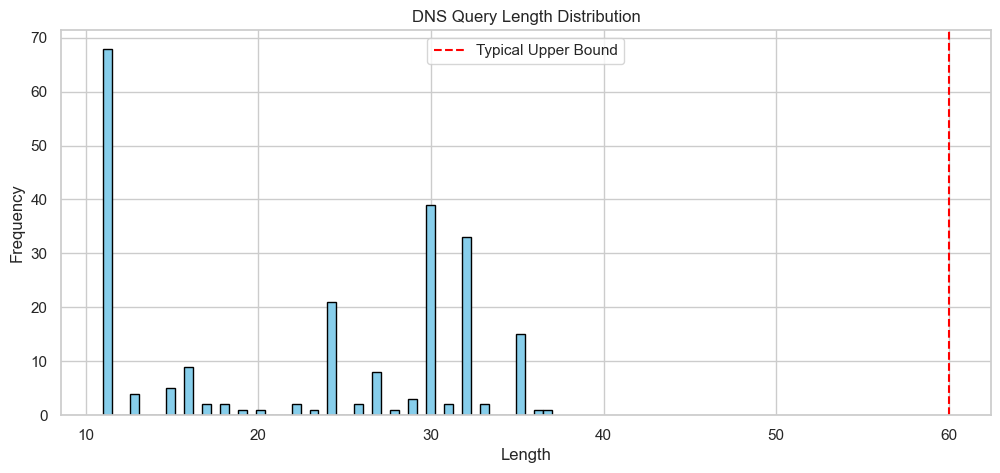

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(questions_df['qname_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("DNS Query Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.axvline(x=60, color='red', linestyle='--', label='Typical Upper Bound')
plt.grid(True)
plt.legend()
plt.show()

**Figure 2.1:** Distribution of DNS query lengths (`qname_length`). Abnormally long query names may suggest data encoding for exfiltration, while uniform lengths could indicate automated beaconing or command-and-control activity.

---
## 2.2 Query Name Entropy

In normal use, DNS queries (e.g., for ```www.google.com, api.github.com```) have relatively predictable query name lengths. But during DNS tunneling, the attacker encodes data (e.g., passwords, files) into the subdomain part of a query, like: 

```aHR0cHM6Ly9leGFtcGxlLmNvbQ==.maliciousdomain.com```.

Suspicious queries are those that are:
- Longer than usual
- Have high variability in query length
- Contain base64 or hex-encoded strings

All of these result in higher entropy than benign queries. This analysis has to be used in correlation with other metrics to ascertain an attack

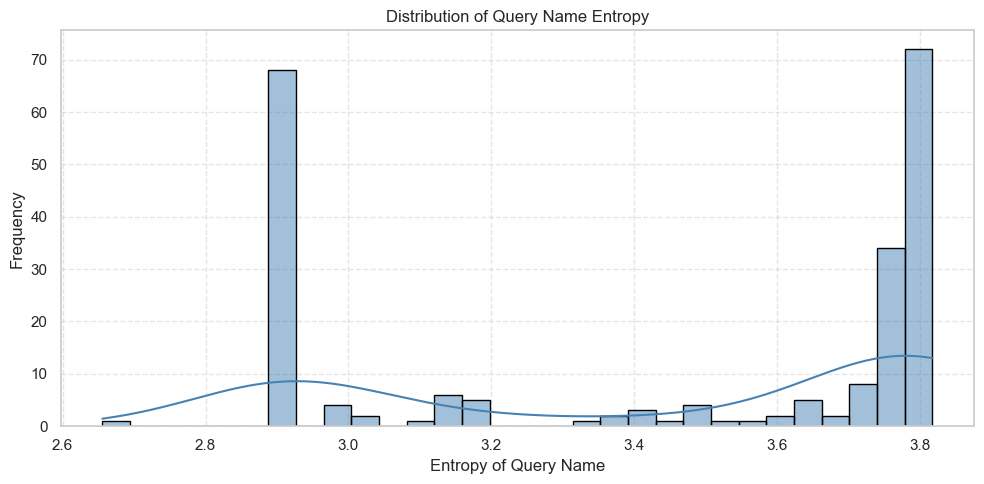

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(questions_df['qname_entropy'], bins=30, kde=True, color="steelblue", edgecolor="black")

plt.title("Distribution of Query Name Entropy")
plt.xlabel("Entropy of Query Name")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Figure 2.2**: Distribution of Query Name Entropy by the Number of Queries

---

## 2.3 Top Queried Domain Names

Beyond analyzing subdomain patterns, it's equally important to examine which domains are being queried most frequently. Domains with an unusually high number of total queries - especially when paired with high subdomain cardinality - are prime suspects for data exfiltration.
These domains often:
- Receive thousands of queries within short periods
- Appear obscure, newly registered, or unrelated to business activity
- Encode data into subdomains to bypass detection

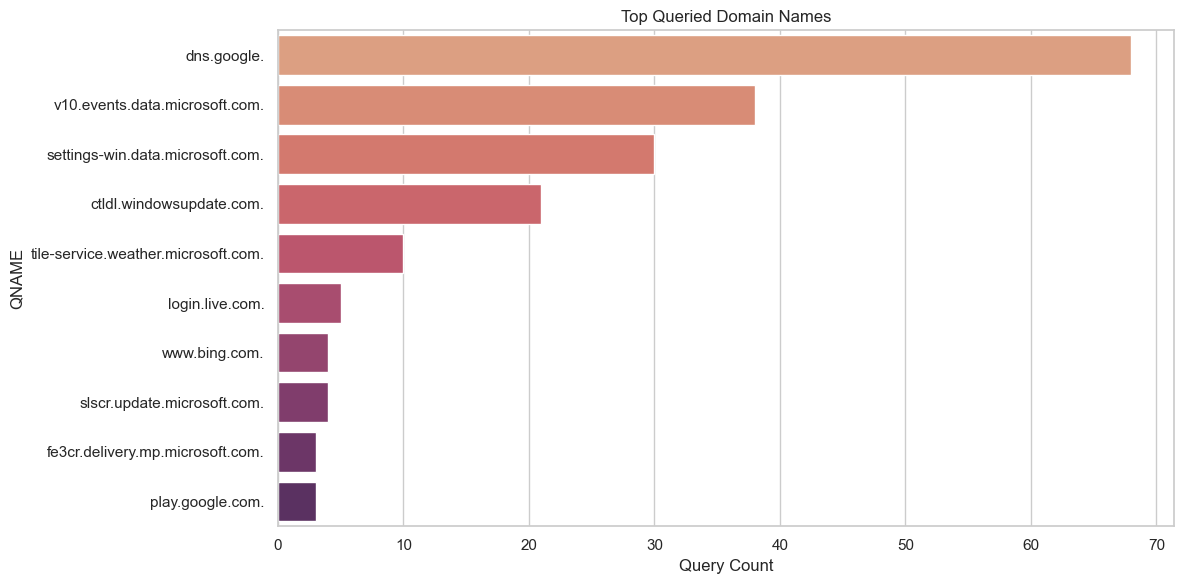

In [8]:
# Show top qnames
top_qnames = questions_df['qname'].value_counts().head(10)
top_qnames_df = top_qnames.reset_index()
top_qnames_df.columns = ['qname', 'count']
top_qnames_df['hue'] = top_qnames_df['qname']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_qnames_df, x='count', y='qname', hue='hue', palette='flare', legend=False)
plt.title("Top Queried Domain Names")
plt.xlabel("Query Count")
plt.ylabel("QNAME")
plt.tight_layout()
plt.show()

**Figure 2.3:** Domains receiving the highest number of DNS queries. A high query count, especially in combination with subdomain encoding, may reveal command-and-control or exfiltration endpoints.

## 2.4 Query Subdomain Name Cardinality

---

Another hallmark of DNS-based exfiltration is the use of many unique subdomains under the same root domain. Attackers often encode sensitive data into subdomains — and then repeatedly query these dynamically generated names to leak information bit by bit.

For example, a root domain like ```malicious-domain.com``` might receive dozens or hundreds of queries like:

```
abc123.malicious-domain.com  
username1.password1.malicious-domain.com  
ccnumber.expirydate.ccv.9dkaei.malicious-domain.com  
```
These domains often appear random and are not typically seen in high traffic. The subdomains encode the actual data being exfiltred, either in plain text or base64encoded.

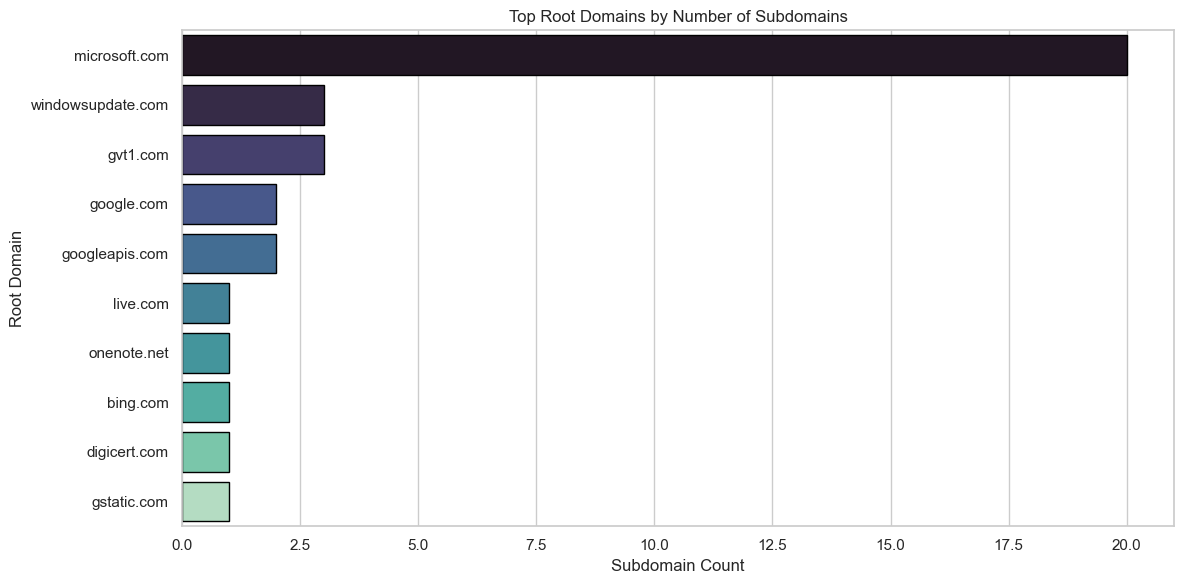

In [9]:
subdomain_map = map_dns_subdomains(questions_df['qname'])

records = [{"root_domain": root, "subdomain_count": len(subs)} for root, subs in subdomain_map.items()]
subdomain_count_df = pd.DataFrame(records).sort_values(by="subdomain_count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=subdomain_count_df.head(10),
    x="subdomain_count",
    y="root_domain",
    hue="root_domain", 
    palette="mako",
    edgecolor="black",
    dodge=False
)
plt.legend([],[], frameon=False)

plt.title("Top Root Domains by Number of Subdomains")
plt.xlabel("Subdomain Count")
plt.ylabel("Root Domain")
plt.tight_layout()
plt.show()


**Figure 2.4**: Root domains with the highest number of unique subdomains. Unusual subdomain diversity, especially for obscure domains, may suggest that DNS is being used to encode and exfiltrate data.

---
## 2.5 DNS Query Volume per Client

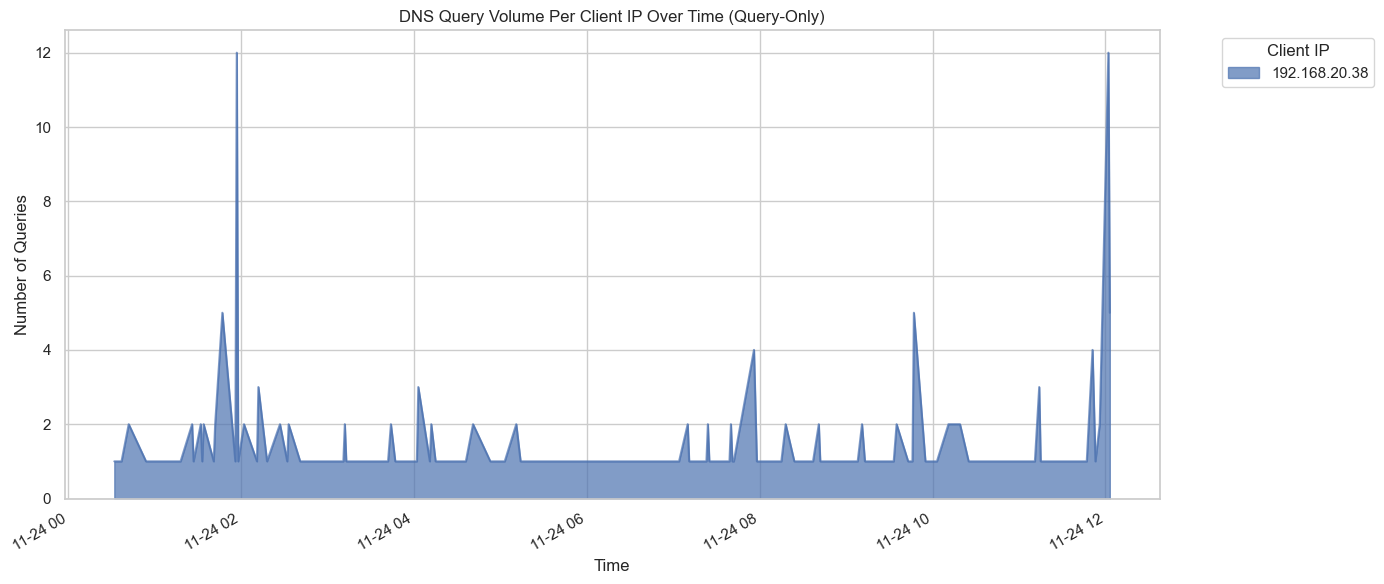

In [10]:
# Round timestamps to nearest minute or hour
questions_df['ts_rounded'] = questions_df['timestamp'].dt.floor('min')  # or 'H' for hourly

# Group by time and client IP (src_ip)
volume_df = (
    questions_df
    .groupby(['ts_rounded', 'src_ip'])
    .size()
    .reset_index(name='query_count')
)

# Pivot to create stacked series format
pivot_df = volume_df.pivot(index='ts_rounded', columns='src_ip', values='query_count').fillna(0)

# Plotting
pivot_df.plot.area(stacked=True, alpha=0.7, figsize=(14, 6))
plt.title("DNS Query Volume Per Client IP Over Time (Query-Only)")
plt.xlabel("Time")
plt.ylabel("Number of Queries")
plt.legend(title="Client IP", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/query_volume_per_client_ip.png")
plt.show()


**Figure 2.5**: DSN Query Volume By Source IP

---
## 2.6 Inter-query Durations

Attackers often attempt to evade detection by spacing out DNS queries at regular intervals — a technique known as beaconing. To analyze this, we calculate the time between successive queries from the same source IP. Beaconing behavior is a common tactic used by malware to maintain communication with a command-and-control (C2) server. It typically involves a host sending out periodic, automated requests—often over DNS—to check in or receive commands. This regularity in communication timing forms the basis for detection. To identify such behavior, we begin by analyzing the distribution of time intervals between successive DNS requests.

If many queries are tightly clustered, or if they follow a repetitive pattern, it could indicate automated data exfiltration behavior.

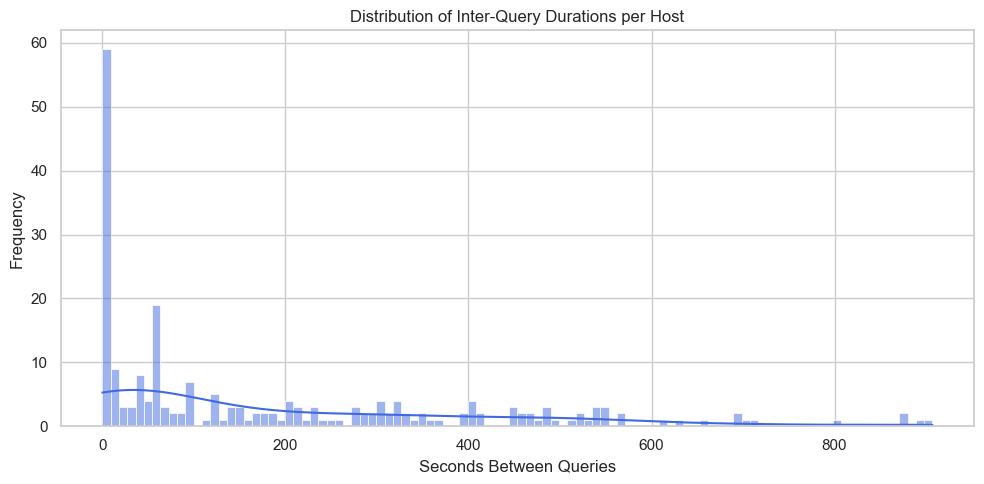

In [11]:
# Sort questions by client and timestamp
questions_df = questions_df.sort_values(by=["src_ip", "timestamp"]).reset_index(drop=True)

# Calculate inter-arrival time between successive queries from the same host
questions_df['interarrival'] = questions_df.groupby('src_ip')['timestamp'].diff().dt.total_seconds()

# Drop the first entries (no previous query)
interarrival_df = questions_df.dropna(subset=['interarrival'])

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.histplot(interarrival_df['interarrival'], bins=100, kde=True, color='royalblue')
plt.title("Distribution of Inter-Query Durations per Host")
plt.xlabel("Seconds Between Queries")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig('../Images/inter_query_durations.png')
plt.show()


**Figure 2.6:** Histogram of DNS query interarrival times. Sharp peaks or evenly spaced intervals may signal regular, automated query behavior — consistent with malware beacons or data tunneling.

---
## 2.7 Beaconing Canditates

To further investigate, we compute the **mean** and **standard deviation** of inter-request intervals for each host. In normal (benign) traffic, inter-request intervals tend to be irregular, resulting in a higher standard deviation. This reflects user-driven or application-triggered behavior with variable timing.
In contrast, automated or beaconing traffic often shows a low standard deviation with a consistent mean—indicating predictable, periodic queries that may signal command-and-control activity or data exfiltration.

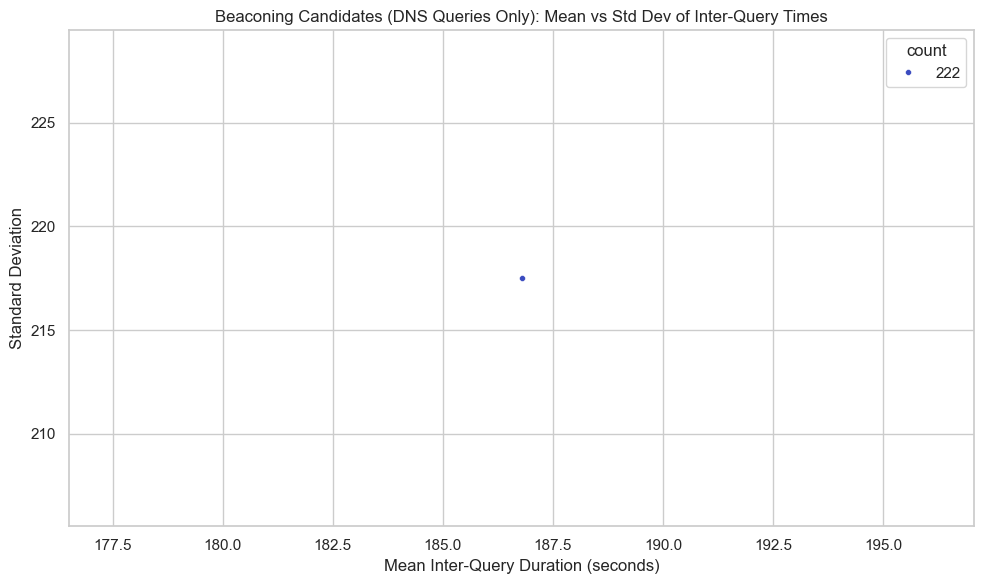

In [12]:
# Group by client IP to compute inter-query stats
beacon_stats = questions_df.groupby("src_ip")['interarrival'].agg(
    count="count",
    mean="mean",
    std="std"
).reset_index()

# Plot: Mean vs Std Dev of inter-query intervals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=beacon_stats,
    x='mean',
    y='std',
    hue='count',
    palette='coolwarm',
    size='count'
)
plt.title("Beaconing Candidates (DNS Queries Only): Mean vs Std Dev of Inter-Query Times")
plt.xlabel("Mean Inter-Query Duration (seconds)")
plt.ylabel("Standard Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()


**Figure 2.7**: Beaconing Candidates based on Inter-Request Timing  

---
## 2.8 DNS Query Timing

Timing patterns in DNS queries can reveal covert data exfiltration:

- **Regular Intervals**: Queries at fixed time gaps suggest automated tunneling tools.
- **Off-Hour Activity**: Traffic during nights/weekends may indicate unauthorized processes.
- **Bursts**: Sudden spikes in query volume can signal rapid data dumping.
- **High-Frequency Drip**: Consistent low-volume queries over time may hide slow exfiltration.

Normal DNS traffic is typically bursty and user-driven. Consistent or unusual timing patterns are strong indicators of suspicious behavior.


In [13]:
questions_df['timestamp'] = pd.to_datetime(questions_df['timestamp'])
questions_df['hour'] = questions_df['timestamp'].dt.floor('h')
heatmap_top = questions_df.groupby(['src_ip', 'hour']).size().unstack(fill_value=0)

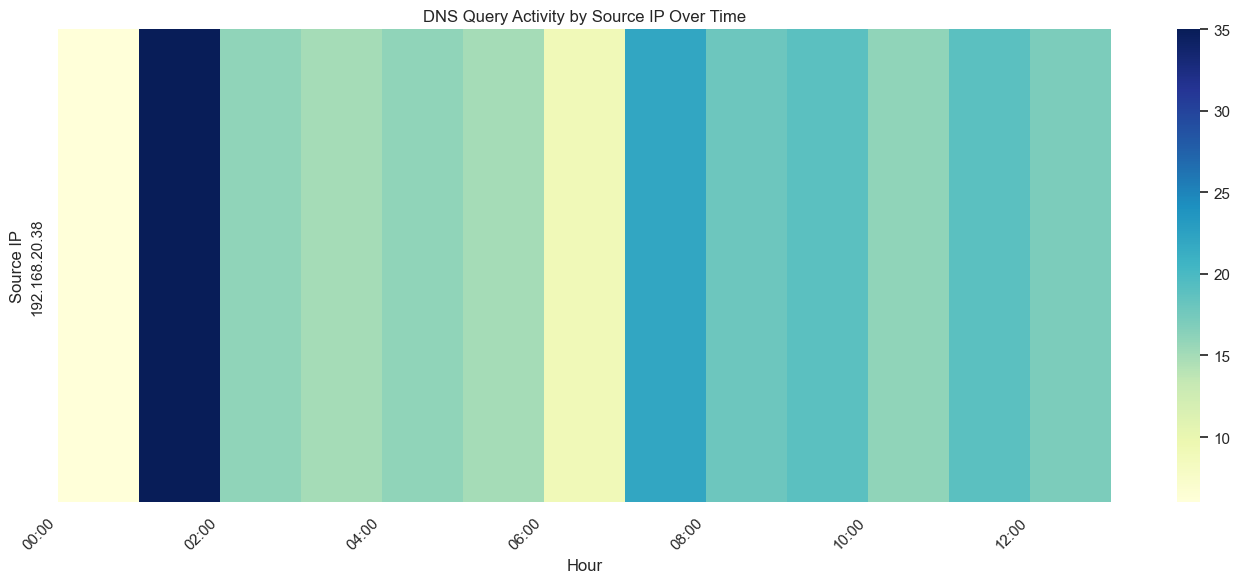

In [14]:
top_ips_unique_domains = (
    questions_df.groupby("src_ip")["qname"]
    .nunique()
    .sort_values(ascending=False)
    .reset_index(name="unique_domains")
)

# Format x-axis labels without seconds
formatted_labels = heatmap_top.columns.strftime('%H:%M')  # or just '%H:%M' if dates not needed

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_top, cmap="YlGnBu", cbar=True)

# Apply cleaner tick labels with fewer ticks
step = 2  # Show every 3rd label (adjust as needed)
plt.xticks(
    ticks=np.arange(0, len(formatted_labels), step),
    labels=formatted_labels[::step],
    rotation=45,
    ha='right'
)

plt.xlabel("Hour")
plt.ylabel("Source IP")
plt.title("DNS Query Activity by Source IP Over Time")
plt.tight_layout()
plt.show()


**Figure 2:8**: DNS Query Activity for each ```src_ip per hour``` - to detect scheduling/persistence.

# 3. Analyzing Responses

---
## 3.1 Response Code Breakdown

RCODE is a 4-bit field in the DNS response message that indicates the outcome of a DNS query. It provides information about the success or failure of the query. RCODE analysis helps detect exfiltration attempts by pointing to irregular patterns that might indicate something suspicious. Here’s are the most relevant RCODE values to analyse in DNS for possible indicators of exfiltration:

**NXDOMAIN (RCODE = 3)**:
NXDOMAIN response is given when a DNS client queries for a non-existent domain. Attackers encode exfiltrated data as domain names, causing the attacker server to issue NXDOMAIN responses. For instance, an attacker could encode data in the subdomain (e.g., ```data12345.domain.com```), leading to NXDOMAIN responses from the server since the domain doesn't actually exist.

**SERVFAIL (RCODE = 2)**:

If an attacker is tunneling data, they might configure a DNS server to return SERVFAIL as a way to avoid detection or simply because the query isn't meant to resolve to a valid IP address.

**REFUSED (RCODE = 5)**:

A REFUSED response occurs when a DNS server refuses to process the query. This might happen when an attacker sends a malformed query or a query to a blacklisted domain.

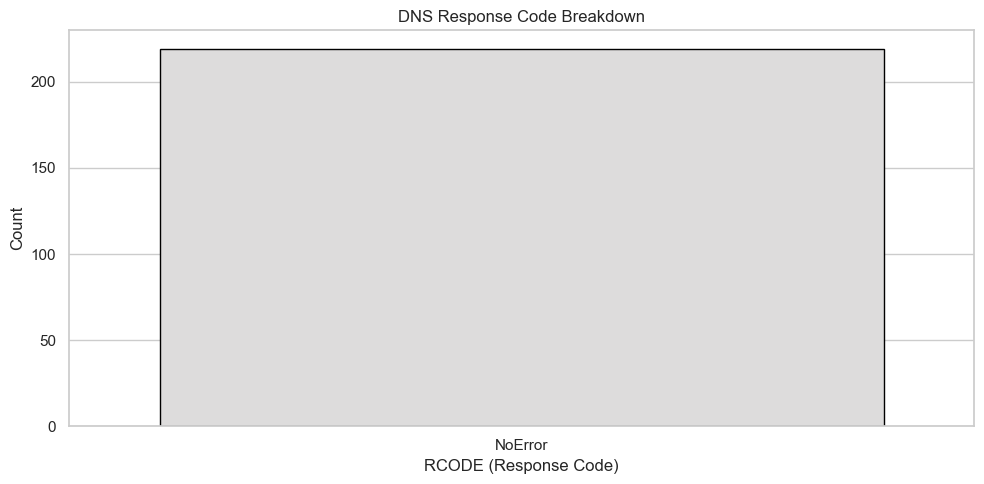

In [15]:
# Map RCODEs to descriptive names
rcode_labels = {
    0: "NoError",
    1: "FormErr",
    2: "ServFail",
    3: "NXDomain",
    4: "NotImp",
    5: "Refused"
}
responses_df["rcode_name"] = responses_df["rcode"].map(rcode_labels).fillna("Other")

# Count occurrences
rcode_counts = responses_df["rcode_name"].value_counts().reset_index()
rcode_counts.columns = ['rcode_name', 'count']
rcode_counts["hue"] = rcode_counts["rcode_name"]
# Plot with hue and no legend
plt.figure(figsize=(10, 5))
sns.barplot(
    data=rcode_counts,
    x='rcode_name', y='count',
    hue='hue', palette='coolwarm', edgecolor='black', legend=False
)
plt.title("DNS Response Code Breakdown")
plt.xlabel("RCODE (Response Code)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Figure 3.1**: DNS Response Code Breakdown

---
### 3.2 Responses with no Answers - Suspicious

In normal DNS operation, if the server sends a response with ```rcode=0```, it means the query from the client was syntactically correct, ie, no errors. In that case, the DNS server should resolve the query and send a valid answer back to the client. If we observe that responses indicate successful queries (```rcode=0```), yet the anwer section has no payload, it is a strong indicator for exfiltration. Attacker controlled DNS servers may not be interested in actually resolving the queries as they only want to receive the exfiltrated data from the client.

To uncover possible data exfiltration, we analyze the temporal distribution of DNS traffic. Specifically, we compare:

- All DNS queries over time
- Suspicious queries with ```rcode=0``` and empty answer sections

This time-series visualization helps us spot bursts, regular intervals, or anomalous surges in suspicious traffic.
This stacked chart highlights when suspicious queries occur. Spikes in ```rcode=0``` queries with empty answers — especially in tight bursts or repeated patterns — may signal automated beaconing or payload transfer intervals.


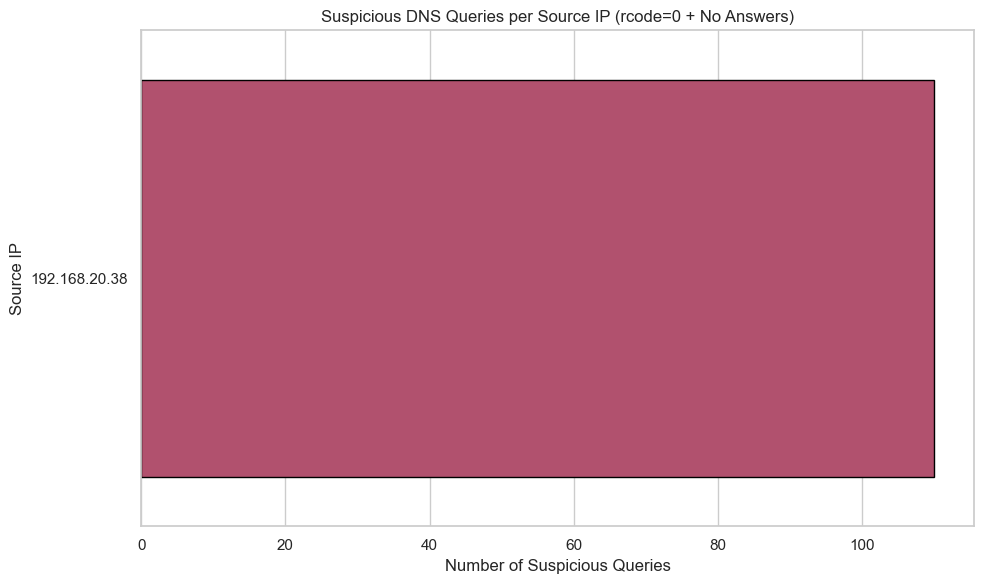

In [16]:
# Define our suspicious queries as those that returned no error, yet the answer was empty.
suspicious_domains = responses_df[
    (responses_df['rcode'] == 0) &
    (responses_df['answers'].apply(lambda a: isinstance(a, list) and len(a) == 0))
]['qname'].dropna().unique()

# Normalize and match from questions side
questions_df['qname_norm'] = questions_df['qname'].str.lower().str.strip('.')
suspicious_domains_norm = pd.Series(suspicious_domains).str.lower().str.strip('.')

suspicious_queries = questions_df[questions_df['qname_norm'].isin(suspicious_domains_norm)].copy()

# Count per source IP
suspicious_by_ip = suspicious_queries['src_ip'].value_counts().reset_index()
suspicious_by_ip.columns = ['src_ip', 'suspicious_query_count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=suspicious_by_ip, x='suspicious_query_count', y='src_ip', palette='flare', edgecolor='black', hue='src_ip', legend=False)
plt.title("Suspicious DNS Queries per Source IP (rcode=0 + No Answers)")
plt.xlabel("Number of Suspicious Queries")
plt.ylabel("Source IP")
plt.tight_layout()
plt.show()


**Figure 3.2**: Number of Suspicious DNS Queries per Source IP. These are valid queries that got a reponse with an empty answer

---
## 3.3 Suspicious DNS Responses over time

We now plot the timeseries of those suspicious DNS queries, superimposed on the rest of the *benign" traffic in a stacked chart. This chart highlights when suspicious queries actually occur.

Sharp surges in red overlay (suspicious traffic) is a potential indicator of data leakage in progress.
In addition to traffic volume spikes, this chart reveals another subtle signal: *periodicity*.
Attackers often configure malware to exfiltrate data at regular intervals to avoid triggering volume-based (*rate-limit*) alerts. These time-based patterns - sometimes referred to as beaconing behavior - can show up as:
- Evenly spaced bursts of suspicious DNS queries
- Consistent minute-by-minute activity, even during low-traffic periods

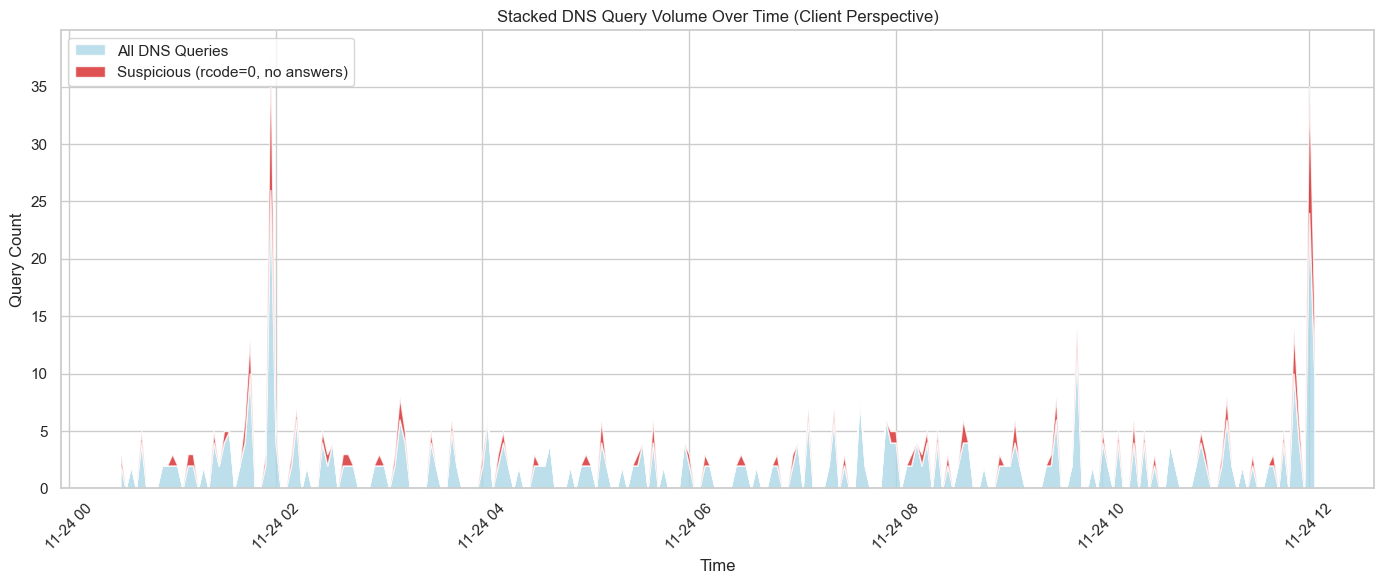

In [17]:
# Resample counts for suspicious responses
suspicious_ts = suspicious_queries.set_index('timestamp').resample('3min').size()

# Do the same for all DNS responses or all DNS traffic
total_ts = df.set_index('timestamp').resample('3min').size()

# Plot stacked
plt.figure(figsize=(14, 6))
plt.stackplot(
    suspicious_ts.index,
    total_ts.reindex(suspicious_ts.index, fill_value=0),
    suspicious_ts,
    labels=["All DNS Queries", "Suspicious (rcode=0, no answers)"],
    colors=["#ADD8E6", "#d62728"],
    alpha=0.8
)
plt.title("Stacked DNS Query Volume Over Time (Client Perspective)")
plt.xlabel("Time")
plt.ylabel("Query Count")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


**Figure 3.3:** Stacked time series showing suspicious queries (`rcode=0` with no answers). Repeating bursts or periodic spikes may indicate *automated exfiltration or beaconing behavior*.

---
## 3.4 Answer TTL Analysis

In performing TTL Analysis we consider the following standard behaviour in DNS responses
- Normal TTLs for legitimate domains often range from 300 to 86400 seconds (5 minutes to 24 hours).
- Suspiciously low TTLs (0–5 seconds) could indicate DNS tunneling or beaconing.
- Clusters around exact values (e.g., many responses with TTL = 60 or 600) may suggest scripted exfiltration infrastructure.

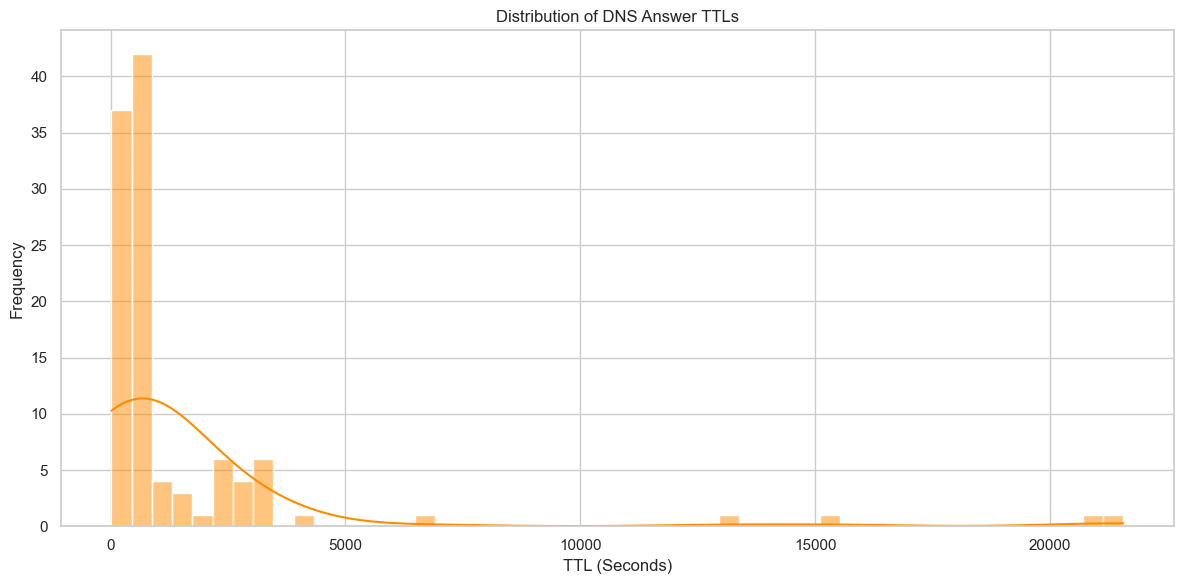

In [18]:
# Ensure 'answers' is list-like and extract TTLs
def extract_ttls(answer_list):
    if isinstance(answer_list, list):
        return [a.get('ttl', None) for a in answer_list if isinstance(a, dict) and 'ttl' in a]
    return []

# Expand TTLs from answers
responses_df['ttls'] = responses_df['answers'].apply(extract_ttls)

# Explode to flatten one TTL per row
ttl_expanded = responses_df[['src_ip', 'qname', 'ttls']].explode('ttls')
ttl_expanded = ttl_expanded.dropna(subset=['ttls'])  # Drop rows with missing TTLs
ttl_expanded['ttls'] = ttl_expanded['ttls'].astype(int)

# Plot TTL distribution
plt.figure(figsize=(12, 6))
sns.histplot(ttl_expanded['ttls'], bins=50, kde=True, color='darkorange')
plt.title("Distribution of DNS Answer TTLs")
plt.xlabel("TTL (Seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


**Figure 3.4**: Distribution of DNS answer TTLs over time

---
## 3.5 Distribution of DNS Answer TTLS ( < 300s )

In the chart below, we filter out DNS answers with TTL < 300s (5 minutes) and plot their distribution for further analysis.

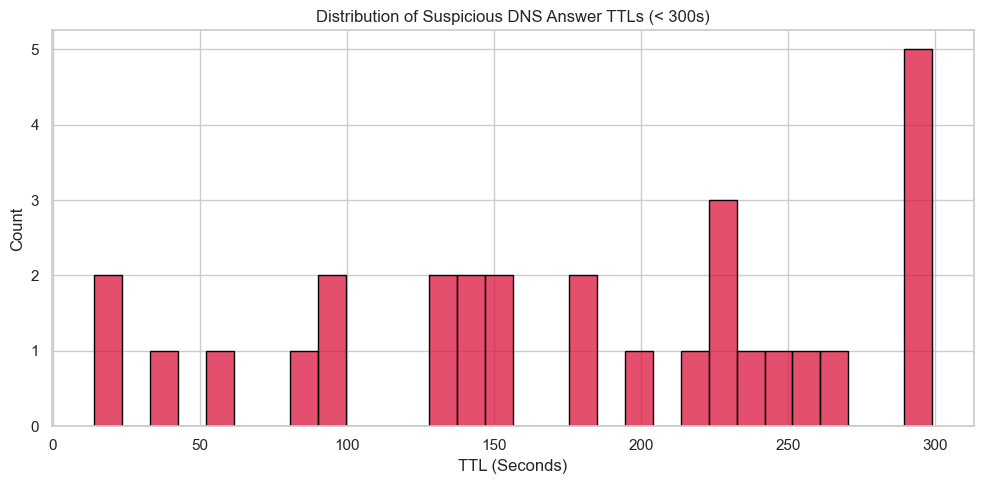

In [19]:
# Filter only TTLs less than 60 seconds
ttl_suspicious = ttl_expanded[ttl_expanded['ttls'] < 300]

# Plot histogram of low TTLs
plt.figure(figsize=(10, 5))
sns.histplot(ttl_suspicious['ttls'], bins=30, color='crimson', edgecolor='black')
plt.title("Distribution of Suspicious DNS Answer TTLs (< 300s)")
plt.xlabel("TTL (Seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Figure 3.5**: Distribution of answer TTLS under a given threshold ( < 300s in this case)

---
## 3.6 Breakdown of DNS Response Types

DNS response types can reveal data exfiltration attempts, as attackers often misuse them to bypass security controls. Here is a brief breakdown of the significance of the various response types to data exfiltration over DNS analysis:  
- **TXT**: Commonly abused to carry arbitrary data; monitor for large or frequent responses.
- **NULL**: Rarely used legitimately; high risk due to ability to carry binary payloads.
- **CNAME**: Used for domain redirection or chaining; look for long or suspicious chains.
- **A/AAAA**: Can encode data in IP addresses; detect via pattern and entropy analysis.
- **MX/SRV/NS**: Less common in abuse but still possible; investigate unexpected use.
  
*Detection Strategy*: Baseline normal DNS behavior and flag anomalies in response types

We first create a mapping of the common reponse types to friendly names

In [20]:
# Mapping from rtype numeric to human-readable name
rtype_map = {
    1: 'A',
    2: 'NS',
    5: 'CNAME',
    6: 'SOA',
    12: 'PTR',
    15: 'MX',
    16: 'TXT',
    28: 'AAAA',
    33: 'SRV',
    255: 'ANY'
}

We then extract the  values of ```rtype``` from the answers and map them to our friendly names. Those that dont fit into the mapping are classified as *other*

In [21]:
# Extract and map rtype values
def extract_rtypes(answers):
    if isinstance(answers, list):
        return [rtype_map.get(a.get('rtype', -1), 'Other') for a in answers if isinstance(a, dict)]
    return []

# Apply and explode
responses_df['rtypes'] = responses_df['answers'].apply(extract_rtypes)
rtypes_exploded = responses_df.explode('rtypes').dropna(subset=['rtypes'])

Finally, we draw a chart of the response types for analysis

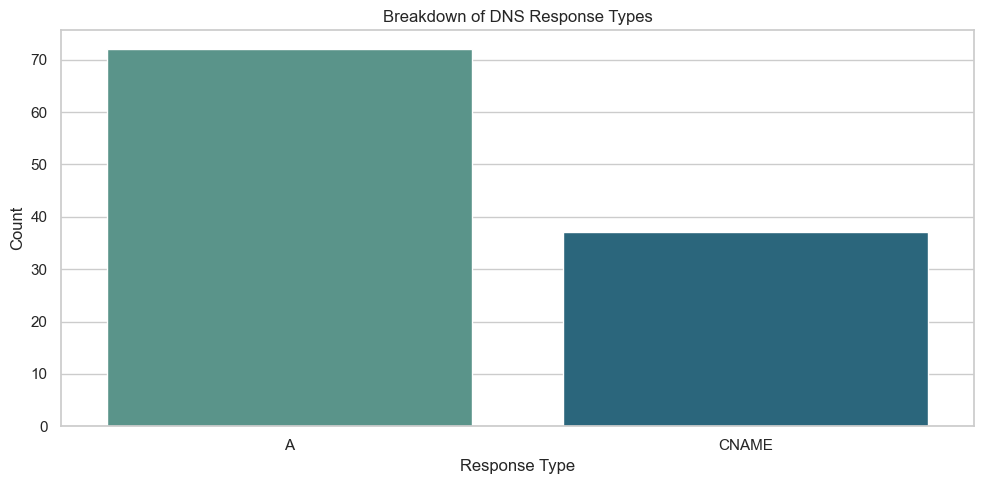

In [22]:
# Plot breakdown
plt.figure(figsize=(10, 5))
sns.countplot(
    data=rtypes_exploded,
    x='rtypes',
    hue='rtypes',
    palette='crest',
    legend=False
)
plt.title("Breakdown of DNS Response Types")
plt.xlabel("Response Type")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('../Images/dns_response_type_breakdown_fixed.png')
plt.show()

**Figure 3.6**: DNS Response Type Breakdown

---
### Next Steps:
- Apply machine learning to model normal vs. anomalous DNS behavior.
- Extend this analysis to include domain reputation checks and threat intelligence enrichment.
- Integrate this workflow into a real-time detection pipeline in Azure DataBricks.

---
## References
- CIC-Bell-DNSExf Dataset: [CIC Website](https://www.unb.ca/cic/datasets/dns-exfiltration.html)
- Corresponding Paper: *Samaneh Mahdavifar, Amgad Hanafy Salem, Princy Victor, Miguel Garzon, Amir H. Razavi, Natasha Hellberg, Arash Habibi Lashkari, "Lightweight Hybrid Detection of Data Exfiltration using DNS based on Machine Learning", The 11th IEEE International Conference on Communication and Network Security (ICCNS), Dec. 3–5, 2021, Beijing Jiaotong University, Weihai, China.*